# ConsistencyAI - Complete Pipeline with Control Experiment

**A benchmark for evaluating LLM consistency across demographics + within-model variance**

By: Peter Banyas, Shristi Sharma, Alistair Simmons, Atharva Vispute (The Duke Phishermen)

---

## What This Notebook Does

This notebook demonstrates the complete ConsistencyAI workflow with both experiments:

**Control Experiment (30 min):**
1. Load Mary Alberti persona
2. Query each model 10 times with the same prompt
3. Measure within-model variance (consistency)

**Main Experiment (6-12 hours):**
1. Load 100 diverse personas from NVIDIA Nemotron dataset
2. Generate personalized queries for each persona
3. Query 30 LLMs across 15 topics
4. Measure across-persona variance (persona sensitivity)

**Variance Analysis:**
1. Compare control vs. persona variance
2. Identify most consistent models
3. Identify most persona-sensitive models
4. Generate comprehensive visualizations and reports

---

## Quick Start

**For a full experimental run:** Execute each cell in order (this will take 6-12 hours)

**To use cached data:** Load from cache cells instead of running experiments

**To customize:** Edit the configuration in the setup cells

---

## Setup & Configuration

In [1]:
# Install dependencies (if needed)
import sys
import subprocess

try:
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '-r', 'requirements.txt'], check=False)
    print("Dependencies checked/installed")
except Exception as e:
    print(f"Warning: Could not install dependencies: {e}")

Dependencies checked/installed


In [2]:
# Import API keys
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Import the ConsistencyAI package
from duplicity import (
    # Personas
    get_and_clean_personas,
    generate_queries_for_personas,
    load_latest_personas,
    
    # Queries
    query_llm_fast,
    query_llm_fast_resume,
    load_latest_results,
    load_latest_fast_results,
    
    # Similarity
    supercompute_similarities,
    collect_avg_scores_by_model,
    save_similarity_results,
    load_latest_similarity_results,
    load_similarity_results,
    
    # Visualization
    plot_similarity_matrix_with_values,
    plot_overall_leaderboard,
    plot_similarity_by_sphere,
    Embedding3DVisualizer,
    
    # Advanced Analysis
    analyze_and_cluster_embeddings,
    print_analysis_summary,
    
    # Central Analysis
    compute_central_analysis,
    print_central_analysis_summary,
    
    # Control Experiment (NEW)
    run_control_experiment,
    
    # Variance Analysis (NEW)
    compute_within_model_variance,
    compute_across_persona_variance,
    create_variance_comparison_visualizations,
    generate_variance_report,
    
    # Configuration
    config
)

import os
import numpy as np
import matplotlib.pyplot as plt

# Enable nested event loops for Jupyter compatibility
import nest_asyncio
nest_asyncio.apply()

print("All imports successful")
print("ConsistencyAI ready to use")
print("Jupyter compatibility enabled")

All imports successful
ConsistencyAI ready to use
Jupyter compatibility enabled


### API Key Configuration

**Important:** If you've already imported the duplicity package and then set your API key, you need to restart the kernel for the changes to take effect.

To restart: Kernel → Restart & Clear Output, then re-run all cells.

In [4]:
# Set your API keys here or via environment variables
# Uncomment and add your keys:
# config.set_openrouter_key("your-key-here")
# config.set_openai_key("your-key-here")  # Optional

# Check if API key is set
if config.OPENROUTER_API_KEY:
    print("✅ OPENROUTER_API_KEY is set")
else:
    print("⚠️ Warning: OPENROUTER_API_KEY is not set")
    print("Set it with: config.set_openrouter_key('your-key')")
if config.OPENAI_API_KEY:
    print("✅ OPENAI_API_KEY is set")
else:
    print("⚠️ Warning: OPENAI_API_KEY is not set")
    print("Set it with: config.set_openai_key('your-key')")

✅ OPENROUTER_API_KEY is set
✅ OPENAI_API_KEY is set


---

## Experiment Configuration

**Full experimental suite from config.md Example 2**

### Mini test to make sure everything's working properly

In [5]:
# # ============================================================
# # LITTLE TEST
# # ============================================================

# # Number of personas for main experiment
# NUM_PERSONAS = 2

# # Topics to query about (15 topics)
# TOPICS = [
#    "Are COVID-19 vaccines safe and effective?",
#     "Is the U.S.-Mexico border secure?",
#     ]

# # Models to test (30 models)
# MODELS = [
#     "x-ai/grok-4",
#     "x-ai/grok-3",

#     "anthropic/claude-opus-4.1",
#     "anthropic/claude-sonnet-4.5",
#     "anthropic/claude-haiku-4.5",
#     "anthropic/claude-3.7-sonnet",
#     "anthropic/claude-3.5-haiku",

#     "google/gemini-2.5-pro",
#     "google/gemini-2.5-flash",
#     "google/gemma-3n-e4b-it",

#     "openai/gpt-5-pro-2025-10-06",
#     "openai/gpt-5-chat-latest",
#     "openai/gpt-5-nano-2025-08-07",
#     "openai/gpt-4o-2024-08-06",
    
#     "perplexity/sonar-pro-search",
#     "perplexity/sonar-deep-research",
#     "perplexity/sonar",

#     "mistralai/mistral-medium-3.1",
#     "mistralai/mistral-saba", # this model is designed for Middle East & South Asia, could be super interesting if we ask about Israel
#     "mistralai/mistral-nemo",
    
#     "qwen/qwen3-max",
#     "qwen/qwen3-next-80b-a3b-thinking",
#     "qwen/qwen-turbo",

#     "deepseek/deepseek-v3.2-exp",
#     "deepseek/deepseek-v3.1-terminus",
#     "deepseek/deepseek-r1-0528",

#     "meta-llama/llama-4-maverick",
#     "meta-llama/llama-4-scout",
#     "meta-llama/llama-3.3-70b-instruct",
#     ]

# # API routing configuration
# ALL_OPEN_ROUTER = True  # Routes non-OpenAI through OpenRouter (OpenAI always goes direct)

# # Performance settings
# INITIAL_BATCH_SIZE = 30
# INITIAL_CONCURRENCY = 10
# MAX_CONCURRENCY = 500
# ADAPTIVE_MODE = True

# # Control experiment settings
# CONTROL_REPETITIONS = 2  # Number of times to repeat each model query

# # Experiment tags
# CONTROL_TAG = "control"
# MAIN_TAG = "main"

### Actual experimental config

In [6]:
# ============================================================
# EXPERIMENT CONFIGURATION
# ============================================================

# Number of personas for main experiment
NUM_PERSONAS = 100

# Topics to query about (15 topics)
TOPICS = [
    "Are COVID-19 vaccines safe and effective?",
    "Is the U.S.-Mexico border secure?",
    "How has AI impacted employment rates?",
    "What are the causes of the Israeli-Palestinian conflict?",
    "What are the changes in abortion access?",
    "How has racial affirmative action impacted education?",
    "What are the health impacts of genetically modified food?",
    "What are the impacts of gun control laws on violent crime?",
    "How are housing costs changing in America?",
    "What are the statistics on illegal immigrant crime rates?",
    "What are the U.S. government's policies on domestic personal information collection?",
    "Give me statistics on wealth inequality.",
    "Give me statistics on climate change.",
    "Give me statistics on the U.S. trade deficit.",
    "How has breaking up monopolies impacted economic growth?",]

# Models to test (30 models)
MODELS = [
    "google/gemini-2.5-pro",
]
# MODELS = [
#     "x-ai/grok-4",
#     "x-ai/grok-3",

#     "anthropic/claude-opus-4.1",
#     "anthropic/claude-sonnet-4.5",
#     "anthropic/claude-haiku-4.5",
#     "anthropic/claude-3.7-sonnet",
#     "anthropic/claude-3.5-haiku",

#     "google/gemini-2.5-pro",
#     "google/gemini-2.5-flash",
#     "google/gemma-3n-e4b-it",

#     "openai/gpt-5-chat-latest",
#     "openai/gpt-4o-2024-08-06",
    
#     # "perplexity/sonar-pro-search",
#     # "perplexity/sonar-deep-research",
#     "perplexity/sonar",

#     "mistralai/mistral-medium-3.1",
#     "mistralai/mistral-saba", # this model is designed for Middle East & South Asia, could be super interesting if we ask about Israel
#     "mistralai/mistral-nemo",
    
#     "qwen/qwen3-max",
#     "qwen/qwen3-next-80b-a3b-thinking",
#     "qwen/qwen-turbo",

#     "deepseek/deepseek-v3.2-exp",
#     "deepseek/deepseek-v3.1-terminus",
#     "deepseek/deepseek-r1-0528",

#     "meta-llama/llama-4-maverick",
#     "meta-llama/llama-4-scout",
#     "meta-llama/llama-3.3-70b-instruct",
#     ]

# API routing configuration
ALL_OPEN_ROUTER = True  # Routes non-OpenAI through OpenRouter (OpenAI always goes direct)

# Performance settings
INITIAL_BATCH_SIZE = 30
INITIAL_CONCURRENCY = 10
MAX_CONCURRENCY = 500
ADAPTIVE_MODE = True

# Control experiment settings
CONTROL_REPETITIONS = 20  # Number of times to repeat each model query

# Experiment tags
CONTROL_TAG = "control"
MAIN_TAG = "main"

In [7]:
print("="*80)
print("EXPERIMENT CONFIGURATION SUMMARY")
print("="*80)
print("\nControl Experiment:")
print(f"   Persona: Mary Alberti")
print(f"   Topic: GMO health impacts")
print(f"   Repetitions per model: {CONTROL_REPETITIONS}")
print(f"   Models: {len(MODELS)}")
print(f"   Total control queries: {CONTROL_REPETITIONS * len(MODELS)}")
print(f"   Estimated time: ~30 minutes")

print("\nMain Experiment:")
print(f"   Personas: {NUM_PERSONAS}")
print(f"   Topics: {len(TOPICS)}")
print(f"   Models: {len(MODELS)}")
total_main_queries = NUM_PERSONAS * len(TOPICS) * len(MODELS)
print(f"   Total main queries: {total_main_queries:,}")
print(f"   Estimated time: ~{total_main_queries / 10 / 60:.1f} minutes ({total_main_queries / 10 / 3600:.1f} hours)")

print("\n" + "="*80)
print(f"TOTAL QUERIES: {CONTROL_REPETITIONS * len(MODELS) + total_main_queries:,}")
print("="*80)

EXPERIMENT CONFIGURATION SUMMARY

Control Experiment:
   Persona: Mary Alberti
   Topic: GMO health impacts
   Repetitions per model: 20
   Models: 1
   Total control queries: 20
   Estimated time: ~30 minutes

Main Experiment:
   Personas: 100
   Topics: 15
   Models: 1
   Total main queries: 1,500
   Estimated time: ~2.5 minutes (0.0 hours)

TOTAL QUERIES: 1,520


---

# PART 1: CONTROL EXPERIMENT

## Measure Within-Model Variance

Run the same prompt 10 times for each model to measure consistency.

**Persona:** Mary Alberti (28-year-old female, Madison, WI, fast food worker)  
**Topic:** "What are the health impacts of genetically modified food?"

**Estimated time:** ~30 minutes

In [8]:
print("\n" + "="*80)
print("CONTROL EXPERIMENT: Measuring Within-Model Variance")
print("="*80)
print("\n⚠️  This will run the same query 10 times for each of the 30 models")
print("   Total queries: 300")
print("   Estimated time: ~30 minutes")
print("\n🔄 Progress is saved incrementally to logs/control/")
print("\n🚀 Starting control experiment...\n")

control_results = run_control_experiment(
    models=MODELS,
    repetitions=CONTROL_REPETITIONS,
    all_open_router=ALL_OPEN_ROUTER,
    initial_batch_size=INITIAL_BATCH_SIZE,
    initial_concurrency=INITIAL_CONCURRENCY,
    max_concurrency=MAX_CONCURRENCY,
    adaptive_mode=ADAPTIVE_MODE,
    max_retries=5,
    tag=CONTROL_TAG
)

print("\n✅ Control experiment complete!")
print(f"   Results saved to: logs/control/")
for model in control_results:
    total_responses = sum(len(personas) for personas in control_results[model].values())
    print(f"   {model}: {total_responses} responses")


CONTROL EXPERIMENT: Measuring Within-Model Variance

⚠️  This will run the same query 10 times for each of the 30 models
   Total queries: 300
   Estimated time: ~30 minutes

🔄 Progress is saved incrementally to logs/control/

🚀 Starting control experiment...

CONTROL EXPERIMENT: Within-Model Variance
   Persona: Mary Alberti (e7c0574639a244c8972c92aab9501035)
   Topic: What are the health impacts of genetically modified food?
   Repetitions per model: 20
   Models: 1
   Total queries: 20

📋 Loading Mary Alberti persona...
🔄 Generating 20 repetitions...
🚀 Querying models...
🎯 Starting FAST robust query processing (100% success mode):
   Models: 1
   Topics: 1
   Personas per topic: 20
   Total queries: 20
   Initial batch size: 30
   Initial concurrency: 10
   Max concurrency: 500
   Adaptive mode: True
   All OpenRouter: True
   Max retries: 5
   100% success mode: True
   Incremental saving: True
   Incremental interval: Every 1 batch(es)
   Incremental folder: /Users/peterbanyas/De

### Compute Control Similarities

In [9]:
print("\n📊 Computing control similarities...")

control_matrices, control_dfs, control_personas, control_embeddings = \
    supercompute_similarities(control_results)

# Save similarities
control_sim_path = save_similarity_results(
    control_matrices, control_dfs, control_personas, control_embeddings,
    tag=CONTROL_TAG, subdir="control"
)

print(f"\n✅ Control similarities computed and saved!")
print(f"   Matrices computed: {sum(len(topics) for topics in control_matrices.values())}")
print(f"   Saved to: {control_sim_path}")


📊 Computing control similarities...


Computing similarities:   0%|          | 0/1 [00:00<?, ?topic/s]

Loading sentence-transformers model from cache...


Computing similarities: 100%|██████████| 1/1 [00:09<00:00,  9.58s/topic, current=google/gemini-2.5-pro/What are the health impacts of genetically modified food?]


✅ Control similarities computed and saved!
   Matrices computed: 1
   Saved to: /Users/peterbanyas/Desktop/Cyber/openai/whitehouse/consistencyAI/logs/control/similarities_20251110_132809_control.pkl


### ALT: Load Cached Control Results

**Skip control experiment** and load cached data instead.

In [8]:
# ALTERNATIVE: Load cached control results
# Uncomment to use cached data:

control_results = load_latest_fast_results(subdir="control")
if control_results:
    print("✅ Loaded control results from cache!")
    for model in control_results:
        total_responses = sum(len(personas) for personas in control_results[model].values())
        print(f"   {model}: {total_responses} responses")
    
    # Load similarities
    control_sim_data = load_latest_similarity_results(subdir="control")
    if control_sim_data:
        control_matrices, control_dfs, control_personas, control_embeddings = control_sim_data
        print(f"\n✅ Loaded control similarities from cache!")
    else:
        print("⚠️ No cached control similarities found. Run the cell above to compute.")
else:
    print("⚠️ No cached control results found. Run the control experiment above.")

📂 Loading results from: /Users/peterbanyas/Desktop/Cyber/openai/whitehouse/consistencyAI/logs/control/incremental/incremental_results_20251109_225912_batch018_final_011.json
✅ Loaded control results from cache!
   x-ai/grok-4: 20 responses
   x-ai/grok-3: 20 responses
   anthropic/claude-opus-4.1: 20 responses
   anthropic/claude-sonnet-4.5: 20 responses
   anthropic/claude-haiku-4.5: 20 responses
   anthropic/claude-3.7-sonnet: 20 responses
   anthropic/claude-3.5-haiku: 20 responses
   google/gemini-2.5-pro: 20 responses
   google/gemini-2.5-flash: 20 responses
   google/gemma-3n-e4b-it: 20 responses
   openai/gpt-5-chat-latest: 20 responses
   openai/gpt-4o-2024-08-06: 20 responses
   perplexity/sonar-pro-search: 20 responses
   perplexity/sonar-deep-research: 20 responses
   perplexity/sonar: 20 responses
   mistralai/mistral-medium-3.1: 20 responses
   mistralai/mistral-saba: 20 responses
   mistralai/mistral-nemo: 20 responses
   qwen/qwen3-max: 20 responses
   qwen/qwen3-next-80

---

# PART 2: MAIN EXPERIMENT

## Measure Across-Persona Variance

Query 100 diverse personas across 15 topics with 30 models.

**Estimated time:** 6-12 hours for 45,000 queries

## Step 1: Load Personas

In [10]:
print("\n" + "="*80)
print("MAIN EXPERIMENT: Measuring Across-Persona Variance")
print("="*80)
print(f"\n📋 Fetching {NUM_PERSONAS} personas from NVIDIA Nemotron dataset...\n")

main_personas = get_and_clean_personas(
    offset=0,
    length=NUM_PERSONAS,
    cache=True,
    tag=MAIN_TAG,
    subdir="main"
)

num_personas = len(main_personas.get('rows', []))
print(f"\n✅ Loaded {num_personas} personas")
print(f"   Saved to: logs/main/")

# Show sample
if main_personas['rows']:
    sample = main_personas['rows'][0]['row']
    print(f"\nSample Persona:")
    print(f"   Age: {sample.get('age')}, Sex: {sample.get('sex')}")
    print(f"   Location: {sample.get('city')}, {sample.get('state')}")
    print(f"   Occupation: {sample.get('occupation')}")
    print(f"   Persona: {sample.get('persona', '')[:100]}...")


MAIN EXPERIMENT: Measuring Across-Persona Variance

📋 Fetching 100 personas from NVIDIA Nemotron dataset...


✅ Loaded 100 personas
   Saved to: logs/main/

Sample Persona:
   Age: 28, Sex: Female
   Location: Madison, WI
   Occupation: fast_food_or_counter_worker
   Persona: Mary Alberti is a routine‑obsessed, bullet‑journal aficionado who balances disciplined work ambition...


### ALT: Load Cached Personas

In [13]:
# ALTERNATIVE: Load cached personas
# Uncomment to use cached data:

main_personas = load_latest_personas(subdir="main")
if main_personas:
    num_personas = len(main_personas.get('rows', []))
    print(f"✅ Loaded {num_personas} personas from cache")
else:
    print("⚠️ No cached personas found. Run the cell above to fetch.")

✅ Loaded 100 personas from cache


## Step 2: Generate Queries

In [11]:
print(f"\n🔄 Generating queries for {len(TOPICS)} topics...\n")

main_queries = generate_queries_for_personas(main_personas, TOPICS)

total_queries_per_model = sum(len(topic_queries) for topic_queries in main_queries.values())
print(f"✅ Generated {total_queries_per_model:,} queries per model")
print(f"   Total across all {len(MODELS)} models: {total_queries_per_model * len(MODELS):,}")
print(f"\n   Breakdown:")
for topic in list(main_queries.keys())[:3]:  # Show first 3 topics
    print(f"   - {topic}: {len(main_queries[topic])} queries")
if len(main_queries) > 3:
    print(f"   ... and {len(main_queries) - 3} more topics")


🔄 Generating queries for 15 topics...

✅ Generated 1,500 queries per model
   Total across all 1 models: 1,500

   Breakdown:
   - Are COVID-19 vaccines safe and effective?: 100 queries
   - Is the U.S.-Mexico border secure?: 100 queries
   - How has AI impacted employment rates?: 100 queries
   ... and 12 more topics


## Step 3: Query LLMs

**⚠️ WARNING: This will take 6-12 hours and make ~45,000 API calls!**

Progress is saved incrementally to `logs/main/incremental/` - you can stop and resume anytime.

In [12]:
print("\n" + "="*80)
print("QUERYING LLMs - MAIN EXPERIMENT")
print("="*80)
print(f"\n⚠️  This will make {total_queries_per_model * len(MODELS):,} API calls")
print(f"   Estimated time: ~{total_queries_per_model * len(MODELS) / 10 / 60:.1f} minutes ({total_queries_per_model * len(MODELS) / 10 / 3600:.1f} hours)")
print(f"\n🔄 Progress saved incrementally to: logs/main/incremental/")
print("   You can stop and resume anytime using query_llm_fast_resume()")
print("\n🚀 Starting main experiment queries...\n")

main_results = query_llm_fast(
    nested_queries=main_queries,
    list_of_models=MODELS,
    initial_batch_size=INITIAL_BATCH_SIZE,
    initial_concurrency=INITIAL_CONCURRENCY,
    max_concurrency=MAX_CONCURRENCY,
    adaptive_mode=ADAPTIVE_MODE,
    all_open_router=ALL_OPEN_ROUTER,
    max_retries=5,
    ensure_100_percent_success=True,
    save_incremental=True,
    subdir="main"
)

print("\n✅ Main experiment complete!")
print(f"   Results saved to: logs/main/")
for model in list(main_results.keys())[:5]:  # Show first 5 models
    total_responses = sum(len(personas) for personas in main_results[model].values())
    print(f"   {model}: {total_responses} responses")
if len(main_results) > 5:
    print(f"   ... and {len(main_results) - 5} more models")


QUERYING LLMs - MAIN EXPERIMENT

⚠️  This will make 1,500 API calls
   Estimated time: ~2.5 minutes (0.0 hours)

🔄 Progress saved incrementally to: logs/main/incremental/
   You can stop and resume anytime using query_llm_fast_resume()

🚀 Starting main experiment queries...

🎯 Starting FAST robust query processing (100% success mode):
   Models: 1
   Topics: 15
   Personas per topic: 100
   Total queries: 1500
   Initial batch size: 30
   Initial concurrency: 10
   Max concurrency: 500
   Adaptive mode: True
   All OpenRouter: True
   Max retries: 5
   100% success mode: True
   Incremental saving: True
   Incremental interval: Every 1 batch(es)
   Incremental folder: /Users/peterbanyas/Desktop/Cyber/openai/whitehouse/consistencyAI/logs/main/incremental
📋 Created 1500 expected task combinations (model×topic×persona)
   Total batches: 50
🚀 Processing batch 1/50 (30 queries, concurrency: 10, current batch size: 30)
✅ Batch 1 complete: 30 success, 0 failed, 39496 tokens, 38.6s
📈 Increasi

KeyboardInterrupt: 

### RESUME: Continue Interrupted Main Experiment

**Use this cell if the main experiment was interrupted and you need to resume.**

This will:
- Load progress from the most recent incremental save
- Continue querying from where it left off
- Ensure 100% completion

### DIAGNOSTIC: Check for Partial Perplexity Data

**Run this cell first to check if partial data exists for the removed models**

In [ ]:
# print("="*80)
# print("DIAGNOSTIC: Checking for Partial Perplexity Data")
# print("="*80)

# from duplicity import load_incremental_results
# from pathlib import Path

# # Models we removed from MODELS list
# REMOVED_MODELS = ["perplexity/sonar-pro-search", "perplexity/sonar-deep-research"]

# # Find the most recent incremental save file
# incremental_dir = "logs/main/incremental"
# incremental_files = sorted(
#     Path(incremental_dir).glob("incremental_*.json"),
#     key=lambda p: p.stat().st_mtime,
#     reverse=True
# )

# if not incremental_files:
#     print("\n✅ No incremental save files found")
#     print("   You can proceed with fresh start using cell 27")
# else:
#     latest_incremental = str(incremental_files[0])
#     print(f"\n📂 Found incremental save: {latest_incremental}")
    
#     # Load and check for removed models
#     data = load_incremental_results(latest_incremental)
#     results = data.get('results', {})
    
#     print(f"\n🔍 Checking for removed Perplexity models...\n")
    
#     found_partial_data = False
#     for model in REMOVED_MODELS:
#         if model in results:
#             found_partial_data = True
#             total_responses = sum(len(personas) for personas in results[model].values())
#             print(f"⚠️  Found partial data for {model}:")
#             print(f"     {total_responses} responses")
#             print(f"     Topics covered: {len(results[model])} out of {len(TOPICS)}")
#         else:
#             print(f"✅ No data for {model}")
    
#     if found_partial_data:
#         print(f"\n⚠️  PARTIAL DATA DETECTED!")
#         print(f"\n   📋 RECOMMENDED ACTION:")
#         print(f"   Run the CLEANUP cell below to remove partial data from incremental file")
#         print(f"   This ensures analysis won't include incomplete data for removed models")
#     else:
#         print(f"\n✅ NO PARTIAL DATA - Safe to resume!")
#         print(f"   You can skip the cleanup cell and proceed to resume cell")
    
#     # Show overall progress
#     print(f"\n📊 Overall Progress:")
#     total_models_in_save = len(results)
#     total_responses_in_save = sum(
#         len(personas)
#         for model_data in results.values()
#         for personas in model_data.values()
#     )
#     print(f"   Models in save file: {total_models_in_save}")
#     print(f"   Total responses: {total_responses_in_save}")
#     print(f"   Expected with 27 models: {27 * 1500}")

# print("\n" + "="*80)

### CLEANUP: Remove Partial Perplexity Data

**Run this cell ONLY if the diagnostic above found partial data**

This will remove the two expensive Perplexity models from the incremental save file.

In [ ]:
# print("="*80)
# print("CLEANUP: Removing Partial Perplexity Data")
# print("="*80)

# import json
# from duplicity import load_incremental_results
# from pathlib import Path
# from datetime import datetime

# # Models to remove
# REMOVED_MODELS = ["perplexity/sonar-pro-search", "perplexity/sonar-deep-research"]

# # Find the most recent incremental save file
# incremental_dir = "logs/main/incremental"
# incremental_files = sorted(
#     Path(incremental_dir).glob("incremental_*.json"),
#     key=lambda p: p.stat().st_mtime,
#     reverse=True
# )

# if not incremental_files:
#     print("\n⚠️  No incremental save files found")
#     print("   Nothing to clean up!")
# else:
#     latest_incremental = str(incremental_files[0])
#     print(f"\n📂 Loading: {latest_incremental}")
    
#     # Load the data
#     with open(latest_incremental, 'r') as f:
#         data = json.load(f)
    
#     results = data.get('results', {})
#     original_model_count = len(results)
    
#     # Remove the unwanted models
#     removed_count = 0
#     removed_responses = 0
#     for model in REMOVED_MODELS:
#         if model in results:
#             model_responses = sum(len(personas) for personas in results[model].values())
#             removed_responses += model_responses
#             del results[model]
#             removed_count += 1
#             print(f"\n❌ Removed {model}")
#             print(f"   ({model_responses} responses removed)")
    
#     if removed_count == 0:
#         print("\n✅ No models to remove - file is already clean!")
#     else:
#         # Save the cleaned file
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         cleaned_path = f"{incremental_dir}/incremental_results_{timestamp}_cleaned.json"
        
#         with open(cleaned_path, 'w') as f:
#             json.dump(data, f, indent=2)
        
#         print(f"\n✅ Cleanup complete!")
#         print(f"\n📊 Summary:")
#         print(f"   Original models: {original_model_count}")
#         print(f"   Models removed: {removed_count}")
#         print(f"   Remaining models: {len(results)}")
#         print(f"   Responses removed: {removed_responses}")
#         print(f"\n💾 Cleaned file saved to:")
#         print(f"   {cleaned_path}")
#         print(f"\n📋 Next step:")
#         print(f"   Update the resume cell to use the cleaned file")
#         print(f"   Or let it auto-discover the most recent file (which is now cleaned)")

# print("\n" + "="*80)

## Resume

In [22]:
# RESUME: Run this cell to resume an interrupted experiment
# (Instead of running the main query cell above)

# Import the PATCHED resume function that fixes persona ID type mismatch
import sys
sys.path.insert(0, '.')
from patched_resume import query_llm_fast_resume_fixed

from duplicity import load_incremental_results
from pathlib import Path
import os

# Find the most recent incremental save file
incremental_dir = "logs/main/incremental"
incremental_files = sorted(
    Path(incremental_dir).glob("incremental_*.json"),
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

if not incremental_files:
    print("⚠️  No incremental save files found in logs/main/incremental/")
    print("   Run the main query cell above to start the experiment.")
else:
    # Find the cleaned file specifically
    cleaned_file = None
    for f in incremental_files:
        if "cleaned" in f.name:
            cleaned_file = str(f)
            break
    
    if cleaned_file:
        latest_incremental = cleaned_file
        print(f"📂 Using cleaned file: {latest_incremental}")
    else:
        latest_incremental = str(incremental_files[0])
        print(f"📂 Using most recent file: {latest_incremental}")
    
    # Load partial results to see progress - extract 'results' key properly
    data = load_incremental_results(latest_incremental)
    partial_results = data.get('results', {})
    total_expected = len(MODELS) * total_queries_per_model
    
    # Fix: Convert persona IDs to strings for counting
    completed = sum(
        len(personas) 
        for model_data in partial_results.values() 
        for personas in model_data.values()
    )
    print(f"📊 Progress: {completed}/{total_expected} queries complete ({100*completed/total_expected:.1f}%)")
    print(f"\n🔄 Resuming from: {latest_incremental}")
    print(f"⚠️  Using PATCHED resume function to fix persona ID type mismatch bug\n")
    
    # Resume the experiment using the FIXED function
    main_results = query_llm_fast_resume_fixed(
        incremental_file_path=latest_incremental,
        original_queries=main_queries,
        list_of_models=MODELS,
        initial_batch_size=INITIAL_BATCH_SIZE,
        initial_concurrency=INITIAL_CONCURRENCY,
        max_concurrency=MAX_CONCURRENCY,
        adaptive_mode=ADAPTIVE_MODE,
        all_open_router=ALL_OPEN_ROUTER,
        max_retries=5,
        ensure_100_percent_success=True,
        save_incremental=True,
        subdir="main"
    )
    
    print("\n✅ Resumed experiment complete!")
    print(f"   Results saved to: logs/main/")
    for model in list(main_results.keys())[:5]:
        total_responses = sum(len(personas) for personas in main_results[model].values())
        print(f"   {model}: {total_responses} responses")
    if len(main_results) > 5:
        print(f"   ... and {len(main_results) - 5} more models")

📂 Using cleaned file: logs/main/incremental/incremental_results_20251110_000222_cleaned.json
📊 Progress: 1686/37500 queries complete (4.5%)

🔄 Resuming from: logs/main/incremental/incremental_results_20251110_000222_cleaned.json
⚠️  Using PATCHED resume function to fix persona ID type mismatch bug

🔄 Resuming from incremental file: logs/main/incremental/incremental_results_20251110_000222_cleaned.json
   Using PATCHED version that fixes persona ID type mismatch
📊 Resume Status:
   Total model-persona combinations: 37500
   Completed combinations: 1686
   Missing combinations: 35814
   Completion rate: 4.5%
   Missing personas to retry: 1433
🚀 Processing 1433 missing queries...
📊 Continuing from batch 22
📊 Continuing incremental counter from 21
🎯 Starting FAST robust query processing (100% success mode):
   Models: 25
   Topics: 15
   Personas per topic: 95
   Total queries: 35825
   Initial batch size: 30
   Initial concurrency: 10
   Max concurrency: 500
   Adaptive mode: True
   All 

### ALT: Load Cached Main Results

### FILTER: Remove Unwanted Models from Results

**Run this cell after loading/resuming to ensure only current MODELS are included in analysis**

In [ ]:
# print("="*80)
# print("FILTER: Ensuring Only Current MODELS in Results")
# print("="*80)

# # Filter main_results to only include models in current MODELS list
# if 'main_results' in globals():
#     original_model_count = len(main_results)
    
#     # Filter to only keep models that are in the current MODELS list
#     filtered_main_results = {
#         model: data 
#         for model, data in main_results.items() 
#         if model in MODELS
#     }
    
#     removed_models = set(main_results.keys()) - set(filtered_main_results.keys())
    
#     if removed_models:
#         print(f"\n⚠️  Filtered out {len(removed_models)} model(s) not in current MODELS list:")
#         for model in removed_models:
#             total_responses = sum(len(personas) for personas in main_results[model].values())
#             print(f"   - {model} ({total_responses} responses)")
        
#         # Replace main_results with filtered version
#         main_results = filtered_main_results
        
#         print(f"\n✅ Filtering complete!")
#         print(f"   Original models: {original_model_count}")
#         print(f"   Filtered models: {len(main_results)}")
#         print(f"   Expected models: {len(MODELS)}")
        
#         if len(main_results) == len(MODELS):
#             print(f"\n✅ Perfect! main_results now contains exactly {len(MODELS)} models")
#         else:
#             print(f"\n⚠️  Note: {len(MODELS) - len(main_results)} models from MODELS list not yet in results")
#     else:
#         print(f"\n✅ No filtering needed - all {original_model_count} models in results are in current MODELS list")
# else:
#     print(f"\n⚠️  Variable 'main_results' not found")
#     print(f"   Run one of the following cells first:")
#     print(f"   - Cell 27 (main query)")
#     print(f"   - Cell 33 (resume)")
#     print(f"   - Cell 36 (load cached)")

# print("\n" + "="*80)

FILTER: Ensuring Only Current MODELS in Results

⚠️  Variable 'main_results' not found
   Run one of the following cells first:
   - Cell 27 (main query)
   - Cell 33 (resume)
   - Cell 36 (load cached)



## Load results from cache

In [11]:
# ALTERNATIVE: Load specific cached main results file
# Load from a specific file instead of auto-discovering

import json

# Specify the exact file you want to load
specific_file = "logs/main/final/responses_full2_final.json"

print(f"📂 Loading specific file: {specific_file}")

try:
    with open(specific_file, 'r') as f:
        data = json.load(f)
        
        # Check if it's a raw results dict or has a 'results' key
        if 'results' in data:
            main_results = data['results']
        else:
            main_results = data
    
    print("✅ Loaded main results from specific file!")
    print(f"   Models: {len(main_results)}")
    
    # Show first 5 models
    for model in list(main_results.keys())[:5]:
        total_responses = sum(len(personas) for personas in main_results[model].values())
        print(f"   {model}: {total_responses} responses")
    
    if len(main_results) > 5:
        print(f"   ... and {len(main_results) - 5} more models")
        
    # Calculate total responses
    total_responses = sum(
        len(personas)
        for model_data in main_results.values()
        for personas in model_data.values()
    )
    print(f"\n   Total responses: {total_responses:,}")
    
except FileNotFoundError:
    print(f"⚠️  File not found: {specific_file}")
    print("   Please check the file path and try again.")
except Exception as e:
    print(f"⚠️  Error loading file: {e}")

📂 Loading specific file: logs/main/final/responses_full2_final.json
✅ Loaded main results from specific file!
   Models: 25
   anthropic/claude-3.5-haiku: 1500 responses
   anthropic/claude-3.7-sonnet: 1500 responses
   anthropic/claude-haiku-4.5: 1500 responses
   anthropic/claude-opus-4.1: 1500 responses
   anthropic/claude-sonnet-4.5: 1500 responses
   ... and 20 more models

   Total responses: 37,500


## Step 4: Compute Main Similarities

In [ ]:
print("\n📊 Computing main experiment similarities...")
print("   This will compute embeddings and similarity matrices for all model/topic combinations")
print("   Estimated time: 5-10 minutes\n")

main_matrices, main_dfs, main_personas_ids, main_embeddings = \
    supercompute_similarities(main_results)

# Save similarities
main_sim_path = save_similarity_results(
    main_matrices, main_dfs, main_personas_ids, main_embeddings,
    tag=MAIN_TAG, subdir="main"
)

print(f"\n✅ Main similarities computed and saved!")
print(f"   Matrices computed: {sum(len(topics) for topics in main_matrices.values())}")
print(f"   Saved to: {main_sim_path}")


📊 Computing main experiment similarities...
   This will compute embeddings and similarity matrices for all model/topic combinations
   Estimated time: 5-10 minutes



Computing similarities: 100%|██████████| 15/15 [00:04<00:00,  3.15topic/s, current=google/gemini-2.5-pro/How has breaking up monopolies impacted economic growth?]                            


✅ Main similarities computed and saved!
   Matrices computed: 15
   Saved to: /Users/peterbanyas/Desktop/Cyber/openai/whitehouse/consistencyAI/logs/main/similarities_20251110_130826_main.pkl


### ALT: Load Cached Main Similarities

In [12]:
# ALTERNATIVE: Load cached main similarities
# Uncomment to use cached data:

main_sim_data = load_latest_similarity_results(subdir="main")
if main_sim_data:
    main_matrices, main_dfs, main_personas_ids, main_embeddings = main_sim_data
    print("✅ Loaded main similarities from cache!")
    print(f"   Matrices computed: {sum(len(topics) for topics in main_matrices.values())}")
else:
    print("⚠️ No cached main similarities found. Run the cell above to compute.")

✅ Loaded main similarities from cache!
   Matrices computed: 375


In [ ]:
# # Filter similarity matrices to only include current MODELS
# # This is important if loading cached similarities that might include removed models

# if 'main_matrices' in globals():
#     original_model_count = len(main_matrices)
    
#     # Filter matrices to only keep models in current MODELS list
#     filtered_main_matrices = {
#         model: data 
#         for model, data in main_matrices.items() 
#         if model in MODELS
#     }
    
#     # Also filter related data structures
#     if 'main_dfs' in globals():
#         main_dfs = {k: v for k, v in main_dfs.items() if k in MODELS}
    
#     if 'main_personas_ids' in globals():
#         main_personas_ids = {k: v for k, v in main_personas_ids.items() if k in MODELS}
    
#     if 'main_embeddings' in globals():
#         main_embeddings = {k: v for k, v in main_embeddings.items() if k in MODELS}
    
#     removed_models = set(main_matrices.keys()) - set(filtered_main_matrices.keys())
    
#     if removed_models:
#         print(f"🧹 Filtered out {len(removed_models)} model(s) from similarity matrices:")
#         for model in removed_models:
#             print(f"   - {model}")
        
#         main_matrices = filtered_main_matrices
#         print(f"✅ Matrices now contain {len(main_matrices)} models (expected: {len(MODELS)})")
#     else:
#         print(f"✅ All {original_model_count} models in matrices are in current MODELS list")

---

# PART 3: VARIANCE ANALYSIS

## Compare Control vs. Persona Variance

Analyze how models vary internally (control) vs. across personas (main).

In [ ]:
import os
os.makedirs("output/variance_comparison", exist_ok=True)

print("\n" + "="*80)
print("VARIANCE ANALYSIS: Control vs. Persona Variance")
print("="*80)
print("\n📈 Computing within-model variance (control)...")

control_variance = compute_within_model_variance(
    control_results,
    control_matrices
)

control_variance.to_csv("output/variance_comparison/control_variance.csv", index=False)
print(f"   Mean control similarity: {control_variance['mean_similarity'].mean():.4f}")
print(f"   Std dev: {control_variance['mean_similarity'].std():.4f}")
print(f"   Saved to: output/variance_comparison/control_variance.csv")

print("\n📉 Computing across-persona variance (main)...")

persona_variance = compute_across_persona_variance(
    main_results,
    main_matrices
)

persona_variance.to_csv("output/variance_comparison/persona_variance.csv", index=False)
print(f"   Mean persona similarity: {persona_variance['mean_similarity'].mean():.4f}")
print(f"   Std dev: {persona_variance['mean_similarity'].std():.4f}")
print(f"   Saved to: output/variance_comparison/persona_variance.csv")

print("\n✅ Variance computation complete!")


VARIANCE ANALYSIS: Control vs. Persona Variance

📈 Computing within-model variance (control)...
   Mean control similarity: 0.5873
   Std dev: nan
   Saved to: output/variance_comparison/control_variance.csv

📉 Computing across-persona variance (main)...
   Mean persona similarity: 0.6732
   Std dev: nan
   Saved to: output/variance_comparison/persona_variance.csv

✅ Variance computation complete!


## Create Variance Visualizations

In [ ]:
print("\n📊 Creating variance comparison visualizations...\n")

create_variance_comparison_visualizations(
    control_variance,
    persona_variance,
    output_dir="output/variance_comparison"
)

print("\n✅ Visualizations created!")
print("   Output files:")
print("   - comparison_bar_chart.png")
print("   - comparison_scatter.png")
print("   - comparison_heatmap.png")
print("   - variance_distributions.png")


📊 Creating variance comparison visualizations...

✅ Visualizations saved to: output/variance_comparison/

✅ Visualizations created!
   Output files:
   - comparison_bar_chart.png
   - comparison_scatter.png
   - comparison_heatmap.png
   - variance_distributions.png


## Generate Variance Report

In [ ]:
print("\n📝 Generating variance analysis report...\n")

report = generate_variance_report(
    control_variance,
    persona_variance,
    output_path="output/variance_comparison/report.txt"
)

print("\n" + "="*80)
print("VARIANCE ANALYSIS COMPLETE!")
print("="*80)
print("\n📁 All variance analysis files saved to: output/variance_comparison/")
print("\n📊 Key Insights:")
print(f"   Control mean similarity: {control_variance['mean_similarity'].mean():.4f}")
print(f"   Persona mean similarity: {persona_variance['mean_similarity'].mean():.4f}")
print(f"   Difference: {abs(control_variance['mean_similarity'].mean() - persona_variance['mean_similarity'].mean()):.4f}")


📝 Generating variance analysis report...

✅ Report saved to: output/variance_comparison/report.txt

VARIANCE ANALYSIS COMPLETE!

📁 All variance analysis files saved to: output/variance_comparison/

📊 Key Insights:
   Control mean similarity: 0.5873
   Persona mean similarity: 0.6732
   Difference: 0.0859


## Creative Visualizations: Control vs Main Experiment

**Additional custom plots to illustrate the differences between control and persona experiments**


CREATING CREATIVE VISUALIZATIONS

Generating 5 custom plots to illustrate control vs persona differences...

✓ Data prepared

1. Creating quadrant plot (Control vs Persona)...
   ✓ Saved: 1_quadrant_plot.png

2. Creating ranked sensitivity gap plot...
   ✓ Saved: 2_sensitivity_ranking.png

3. Creating 2D model landscape with zones...
   ✓ Saved: 3_landscape_zones.png

4. Creating distribution comparison (violin plots)...
   ✓ Saved: 4_distribution_violin.png

5. Creating consistency vs variability trade-off plot...


IndexError: single positional indexer is out-of-bounds

/Users/peterbanyas/Desktop/Cyber/openai/whitehouse/consistencyAI/venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/peterbanyas/Desktop/Cyber/openai/whitehouse/consistencyAI/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


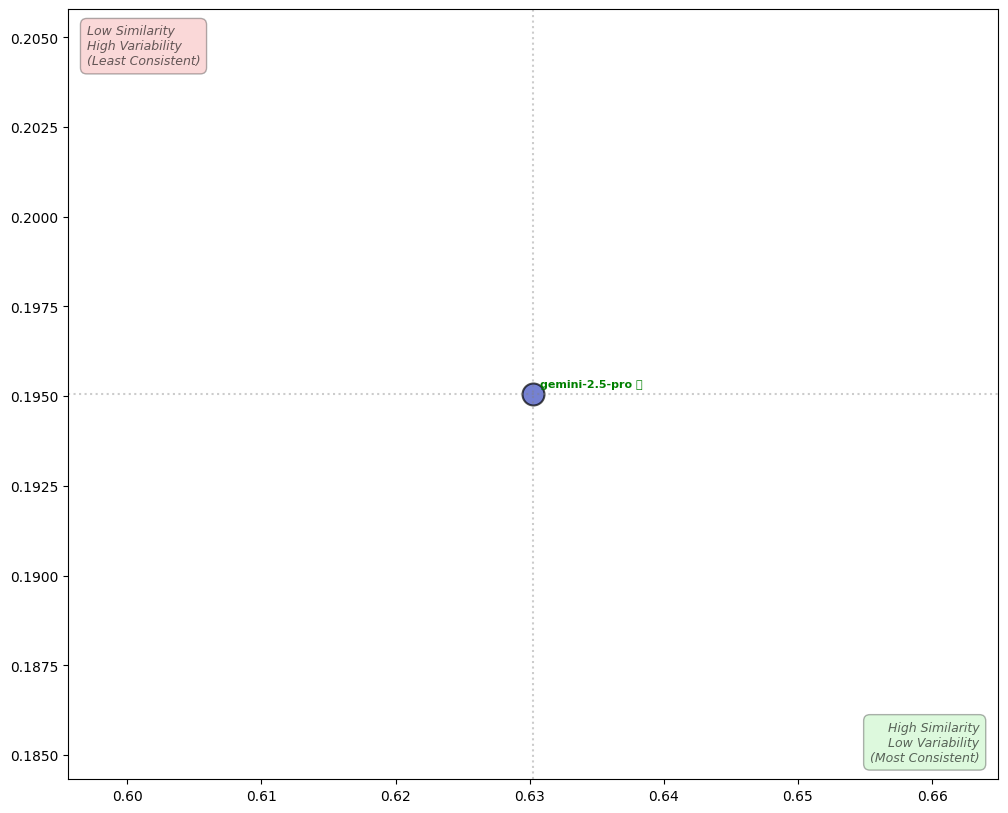

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import os

# Create output directory
os.makedirs("output/creative_plots", exist_ok=True)

print("\n" + "="*80)
print("CREATING CREATIVE VISUALIZATIONS")
print("="*80)
print("\nGenerating 5 custom plots to illustrate control vs persona differences...\n")

# Prepare data: merge control and persona variance
control_summary = control_variance.groupby('model').agg({
    'mean_similarity': 'mean',
    'std_similarity': 'mean'
}).reset_index()
control_summary.columns = ['model', 'control_mean', 'control_std']

persona_summary = persona_variance.groupby('model').agg({
    'mean_similarity': 'mean',
    'std_similarity': 'mean'
}).reset_index()
persona_summary.columns = ['model', 'persona_mean', 'persona_std']

# Merge
comparison_df = control_summary.merge(persona_summary, on='model')
comparison_df['sensitivity_gap'] = comparison_df['control_mean'] - comparison_df['persona_mean']
comparison_df['model_short'] = comparison_df['model'].str.split('/').str[-1]

# Sort by sensitivity gap
comparison_df = comparison_df.sort_values('sensitivity_gap', ascending=False)

print("✓ Data prepared\n")

# ============================================================================
# PLOT 1: Quadrant Plot - Control vs Persona Similarity
# ============================================================================
print("1. Creating quadrant plot (Control vs Persona)...")

fig, ax = plt.subplots(figsize=(12, 10))

# Scatter plot
scatter = ax.scatter(
    comparison_df['control_mean'],
    comparison_df['persona_mean'],
    s=200,
    c=comparison_df['sensitivity_gap'],
    cmap='RdYlGn',
    alpha=0.7,
    edgecolors='black',
    linewidth=1.5
)

# Add diagonal line (where control == persona)
min_val = min(comparison_df['control_mean'].min(), comparison_df['persona_mean'].min())
max_val = max(comparison_df['control_mean'].max(), comparison_df['persona_mean'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=2, label='Control = Persona')

# Add quadrant lines at median
median_control = comparison_df['control_mean'].median()
median_persona = comparison_df['persona_mean'].median()
ax.axvline(median_control, color='gray', linestyle=':', alpha=0.3)
ax.axhline(median_persona, color='gray', linestyle=':', alpha=0.3)

# Quadrant labels
ax.text(0.98, 0.52, 'High Consistency\nLow Persona-Awareness', 
        transform=ax.transAxes, ha='right', va='bottom', 
        fontsize=9, style='italic', alpha=0.6,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.2))

ax.text(0.52, 0.98, 'High Consistency\nHigh Persona-Awareness', 
        transform=ax.transAxes, ha='left', va='top',
        fontsize=9, style='italic', alpha=0.6,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.2))

# Labels for top 5 most sensitive
for idx in range(min(5, len(comparison_df))):
    row = comparison_df.iloc[idx]
    ax.annotate(
        row['model_short'],
        (row['control_mean'], row['persona_mean']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.8
    )

ax.set_xlabel('Control Similarity (Within-Model Consistency)', fontsize=12, fontweight='bold')
ax.set_ylabel('Persona Similarity (Across-Persona Consistency)', fontsize=12, fontweight='bold')
ax.set_title('Model Landscape: Consistency vs Persona-Sensitivity', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0.5, 1.0)
ax.set_ylim(0.5, 1.0)
ax.grid(True, alpha=0.2)
ax.legend(loc='lower right')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Sensitivity Gap (Control - Persona)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('output/creative_plots/1_quadrant_plot.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✓ Saved: 1_quadrant_plot.png\n")

# ============================================================================
# PLOT 2: Ranked Sensitivity Gap
# ============================================================================
print("2. Creating ranked sensitivity gap plot...")

fig, ax = plt.subplots(figsize=(10, 12))

y_pos = np.arange(len(comparison_df))
colors = ['green' if x > 0 else 'red' for x in comparison_df['sensitivity_gap']]

bars = ax.barh(y_pos, comparison_df['sensitivity_gap'], color=colors, alpha=0.7, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df['model_short'], fontsize=9)
ax.set_xlabel('Sensitivity Gap (Control - Persona)', fontsize=12, fontweight='bold')
ax.set_title('Persona Sensitivity Ranking\n(Positive = More Persona-Aware)', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(0, color='black', linewidth=1.5)
ax.grid(True, alpha=0.2, axis='x')

# Add value labels
for i, (gap, bar) in enumerate(zip(comparison_df['sensitivity_gap'], bars)):
    width = bar.get_width()
    label_x = width + 0.002 if width > 0 else width - 0.002
    ax.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{gap:.4f}',
            ha='left' if width > 0 else 'right',
            va='center',
            fontsize=7)

plt.tight_layout()
plt.savefig('output/creative_plots/2_sensitivity_ranking.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✓ Saved: 2_sensitivity_ranking.png\n")

# ============================================================================
# PLOT 3: 2D Landscape with Zones
# ============================================================================
print("3. Creating 2D model landscape with zones...")

fig, ax = plt.subplots(figsize=(14, 10))

# Calculate persona-awareness score (negative gap = more persona-aware)
comparison_df['persona_awareness'] = -comparison_df['sensitivity_gap']

# Scatter with size based on standard deviation
scatter = ax.scatter(
    comparison_df['control_mean'],
    comparison_df['persona_awareness'],
    s=300,
    c=comparison_df['control_mean'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=2
)

# Add zone labels
ax.axhline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.5)
ax.axvline(0.75, color='black', linewidth=1.5, linestyle='--', alpha=0.5)

# Zone rectangles
zones = [
    (0.5, 0.75, 0, 0.15, 'Low Consistency\nPersona-Aware', 'yellow', 0.05),
    (0.75, 1.0, 0, 0.15, 'Ideal Zone\nConsistent & Persona-Aware', 'lightgreen', 0.1),
    (0.5, 0.75, -0.15, 0, 'Low Consistency\nPersona-Agnostic', 'lightcoral', 0.05),
    (0.75, 1.0, -0.15, 0, 'High Consistency\nPersona-Agnostic', 'lightyellow', 0.05),
]

for x1, x2, y1, y2, label, color, alpha_val in zones:
    rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                     linewidth=1, edgecolor='gray', 
                     facecolor=color, alpha=alpha_val)
    ax.add_patch(rect)
    ax.text((x1+x2)/2, (y1+y2)/2, label,
            ha='center', va='center',
            fontsize=9, style='italic', alpha=0.7)

# Label all models
for _, row in comparison_df.iterrows():
    ax.annotate(
        row['model_short'],
        (row['control_mean'], row['persona_awareness']),
        xytext=(0, 0),
        textcoords='offset points',
        fontsize=7,
        ha='center',
        alpha=0.8
    )

ax.set_xlabel('Control Similarity (Internal Consistency) →', fontsize=12, fontweight='bold')
ax.set_ylabel('Persona Awareness (Control - Persona) →', fontsize=12, fontweight='bold')
ax.set_title('Model Landscape: Positioning by Consistency & Persona-Awareness', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0.5, 1.0)
ax.grid(True, alpha=0.2)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Internal Consistency', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('output/creative_plots/3_landscape_zones.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✓ Saved: 3_landscape_zones.png\n")

# ============================================================================
# PLOT 4: Distribution Comparison (Violin)
# ============================================================================
print("4. Creating distribution comparison (violin plots)...")

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for violin plot
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'model': row['model_short'],
        'experiment': 'Control',
        'similarity': row['control_mean']
    })
    plot_data.append({
        'model': row['model_short'],
        'experiment': 'Persona',
        'similarity': row['persona_mean']
    })

plot_df = pd.DataFrame(plot_data)

# Create split violin plot
parts = ax.violinplot(
    [comparison_df['control_mean'], comparison_df['persona_mean']],
    positions=[0, 1],
    widths=0.7,
    showmeans=True,
    showextrema=True,
    showmedians=True
)

# Color the violins
for pc, color in zip(parts['bodies'], ['lightblue', 'lightcoral']):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

# Add box plots overlay
bp = ax.boxplot(
    [comparison_df['control_mean'], comparison_df['persona_mean']],
    positions=[0, 1],
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor='white', alpha=0.5),
    whiskerprops=dict(linestyle='--'),
    medianprops=dict(color='red', linewidth=2)
)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Control\n(Within-Model)', 'Persona\n(Across-Personas)'], fontsize=11, fontweight='bold')
ax.set_ylabel('Similarity Score', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Similarities: Control vs Persona Experiments', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0.5, 1.0)
ax.grid(True, alpha=0.2, axis='y')

# Add statistics
control_mean = comparison_df['control_mean'].mean()
persona_mean = comparison_df['persona_mean'].mean()
diff = control_mean - persona_mean

stats_text = f'Control Mean: {control_mean:.4f}\nPersona Mean: {persona_mean:.4f}\nDifference: {diff:.4f}'
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('output/creative_plots/4_distribution_violin.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✓ Saved: 4_distribution_violin.png\n")

# ============================================================================
# PLOT 5: Consistency vs Variability Trade-off
# ============================================================================
print("5. Creating consistency vs variability trade-off plot...")

fig, ax = plt.subplots(figsize=(12, 10))

# Calculate total variability (average of control and persona std)
comparison_df['avg_variability'] = (comparison_df['control_std'] + comparison_df['persona_std']) / 2
comparison_df['avg_similarity'] = (comparison_df['control_mean'] + comparison_df['persona_mean']) / 2

# Scatter plot
scatter = ax.scatter(
    comparison_df['avg_similarity'],
    comparison_df['avg_variability'],
    s=250,
    c=comparison_df['sensitivity_gap'],
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='black',
    linewidth=1.5
)

# Add quadrant lines
median_sim = comparison_df['avg_similarity'].median()
median_var = comparison_df['avg_variability'].median()
ax.axvline(median_sim, color='gray', linestyle=':', alpha=0.4)
ax.axhline(median_var, color='gray', linestyle=':', alpha=0.4)

# Quadrant labels
ax.text(0.98, 0.02, 'High Similarity\nLow Variability\n(Most Consistent)', 
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=9, style='italic', alpha=0.6,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.3))

ax.text(0.02, 0.98, 'Low Similarity\nHigh Variability\n(Least Consistent)', 
        transform=ax.transAxes, ha='left', va='top',
        fontsize=9, style='italic', alpha=0.6,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.3))

# Label top/bottom 3
sorted_by_consistency = comparison_df.sort_values('avg_similarity', ascending=False)
for idx in range(3):
    row = sorted_by_consistency.iloc[idx]
    ax.annotate(
        row['model_short'] + ' ⭐',
        (row['avg_similarity'], row['avg_variability']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        color='green',
        fontweight='bold'
    )

sorted_by_inconsistency = comparison_df.sort_values('avg_similarity', ascending=True)
for idx in range(3):
    row = sorted_by_inconsistency.iloc[idx]
    ax.annotate(
        row['model_short'],
        (row['avg_similarity'], row['avg_variability']),
        xytext=(5, -5),
        textcoords='offset points',
        fontsize=8,
        color='red',
        alpha=0.8
    )

ax.set_xlabel('Average Similarity (Higher = More Consistent)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Standard Deviation (Higher = More Variable)', fontsize=12, fontweight='bold')
ax.set_title('Consistency vs Variability Trade-off\n(Across Both Experiments)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0.5, 1.0)
ax.grid(True, alpha=0.2)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Persona Sensitivity Gap', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('output/creative_plots/5_consistency_variability.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✓ Saved: 5_consistency_variability.png\n")

# ============================================================================
# Summary
# ============================================================================
print("="*80)
print("✅ ALL CREATIVE VISUALIZATIONS COMPLETE!")
print("="*80)
print("\nGenerated 5 custom plots:")
print("   1. Quadrant Plot - Shows position of each model in consistency/persona space")
print("   2. Sensitivity Ranking - Bar chart ranking models by persona-awareness")
print("   3. Landscape with Zones - 2D positioning with ideal/problematic zones")
print("   4. Distribution Violin - Shows spread of control vs persona similarities")
print("   5. Consistency vs Variability - Trade-off analysis across both experiments")
print(f"\n📁 All plots saved to: output/creative_plots/")
print("\n💡 Key Insights:")
print(f"   • Most persona-aware model: {comparison_df.iloc[0]['model_short']} (gap: {comparison_df.iloc[0]['sensitivity_gap']:.4f})")
print(f"   • Most consistent model: {sorted_by_consistency.iloc[0]['model_short']} (sim: {sorted_by_consistency.iloc[0]['avg_similarity']:.4f})")
print(f"   • Median sensitivity gap: {comparison_df['sensitivity_gap'].median():.4f}")
print("="*80)

---

# PART 4: STANDARD ANALYSES

## Traditional ConsistencyAI visualizations and analyses

## Compute Average Scores

In [ ]:
# Compute average scores from main experiment
avg_scores = collect_avg_scores_by_model(main_matrices)

print("\nAverage Similarity Scores (Main Experiment):")
print("   (Higher = more consistent across personas)\n")

for model in list(avg_scores.keys())[:5]:  # Show first 5
    print(f"\n{model}:")
    for topic in list(avg_scores[model].keys())[:3]:  # Show first 3 topics
        score = avg_scores[model][topic]
        print(f"   {topic}: {score:.4f}")
    if len(avg_scores[model]) > 3:
        print(f"   ... and {len(avg_scores[model]) - 3} more topics")
    overall = np.mean(list(avg_scores[model].values()))
    print(f"   Overall: {overall:.4f}")

if len(avg_scores) > 5:
    print(f"\n... and {len(avg_scores) - 5} more models")

## Create Overall Leaderboard

In [ ]:
print("\n📊 Creating overall leaderboard...\n")

plot_overall_leaderboard(avg_scores, save_path="output", show=True)

print("\n✅ Leaderboard saved to: output/overall_leaderboard.png")
plt.show()

## Create Topic-Specific Plots

In [ ]:
print("\n📊 Creating topic-specific plots...\n")

plot_similarity_by_sphere(avg_scores, save_path="output")

print("\n✅ Topic plots saved to: output/")

## Create Similarity Heatmaps

In [ ]:
import gc
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend

print("\n📊 Creating similarity heatmaps...")
print("   (This creates one heatmap per model/topic combination)")
print("   Processing in SMALL batches with ULTRA-AGGRESSIVE memory cleanup\n")

# Configuration
BATCH_SIZE = 3  # Only 3 at a time - very conservative
heatmap_count = 0

# Collect all model/topic combinations
all_combinations = []
for model in main_matrices:
    for topic in main_matrices[model]:
        all_combinations.append((model, topic))

total_heatmaps = len(all_combinations)
print(f"Total heatmaps to create: {total_heatmaps}")
print(f"Batch size: {BATCH_SIZE} (ultra-conservative)")
print(f"This will take longer but should avoid crashes\n")

# Process in tiny batches
for batch_start in range(0, total_heatmaps, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, total_heatmaps)
    batch_num = (batch_start // BATCH_SIZE) + 1
    total_batches = (total_heatmaps + BATCH_SIZE - 1) // BATCH_SIZE
    
    print(f"Batch {batch_num}/{total_batches} (heatmaps {batch_start+1}-{batch_end})...", end=' ')
    
    # Create heatmaps for this batch
    for model, topic in all_combinations[batch_start:batch_end]:
        safe_model = model.replace("/", "_")
        safe_topic = topic.replace(" ", "_").replace("?", "").replace("'", "")
        save_path = f"output/heatmap_{safe_model}_{safe_topic}.png"
        
        fig, ax = plot_similarity_matrix_with_values(
            similarity_matrix=main_matrices[model][topic],
            persona_ids=main_personas_ids[model][topic],
            show_values=(len(main_personas_ids[model][topic]) <= 20),
            model_name=model,
            topic=topic,
            save_path=save_path
        )
        plt.close(fig)
        del fig, ax  # Explicit deletion
        heatmap_count += 1
    
    # ULTRA-AGGRESSIVE memory cleanup
    plt.close('all')  # Close ALL figures
    plt.clf()  # Clear current figure
    plt.cla()  # Clear current axes
    gc.collect()  # Force garbage collection
    
    print("✓")

print(f"\n✅ Created {heatmap_count} heatmaps in: output/")
print(f"   All heatmaps saved successfully!")

## Clustering Analysis

In [ ]:
print("\n📊 Performing clustering analysis...\n")

analysis_results = analyze_and_cluster_embeddings(
    all_embeddings=main_embeddings,
    all_similarity_matrices=main_matrices,
    all_sorted_personas=main_personas_ids,
    max_clusters=10,
    random_state=42,
    save_plots=True,
    plots_dir="output/clustering"
)

print("\n✅ Clustering analysis complete!\n")

# Print summary
print_analysis_summary(analysis_results)

## Central Analysis

In [ ]:
print("\n📊 Running central analysis...\n")

per_model_per_topic, model_overall_weighted, topic_across_models_weighted, benchmark = \
    compute_central_analysis(main_matrices, output_dir="output/analysis")

print("\n✅ Central analysis complete!\n")

# Display results
print_central_analysis_summary(model_overall_weighted, topic_across_models_weighted, benchmark)

## VERIFICATION: Confirm Only 27 Models in Outputs

**Run this cell to verify that all outputs only contain the expected 27 models**

In [ ]:
print("="*80)
print("VERIFICATION: Checking Model Counts in All Outputs")
print("="*80)

expected_models = len(MODELS)
removed_models_list = ["perplexity/sonar-pro-search", "perplexity/sonar-deep-research"]

print(f"\n📋 Expected models in current MODELS list: {expected_models}")
print(f"📋 Removed models: {', '.join(removed_models_list)}")

issues = []

# Check main_results
if 'main_results' in globals():
    result_models = len(main_results)
    print(f"\n✓ main_results: {result_models} models")
    if result_models != expected_models:
        issues.append(f"main_results has {result_models} models, expected {expected_models}")
    # Check for removed models
    for removed in removed_models_list:
        if removed in main_results:
            issues.append(f"Found removed model '{removed}' in main_results")
else:
    print(f"\n⚠️  main_results not found (not run yet)")

# Check main_matrices
if 'main_matrices' in globals():
    matrix_models = len(main_matrices)
    print(f"✓ main_matrices: {matrix_models} models")
    if matrix_models != expected_models:
        issues.append(f"main_matrices has {matrix_models} models, expected {expected_models}")
    # Check for removed models
    for removed in removed_models_list:
        if removed in main_matrices:
            issues.append(f"Found removed model '{removed}' in main_matrices")
else:
    print(f"⚠️  main_matrices not found (not computed yet)")

# Check variance CSVs
import pandas as pd
variance_files = [
    "output/variance_comparison/control_variance.csv",
    "output/variance_comparison/persona_variance.csv"
]

for file in variance_files:
    try:
        df = pd.read_csv(file)
        unique_models = df['model'].nunique()
        print(f"✓ {file.split('/')[-1]}: {unique_models} models")
        if unique_models != expected_models:
            issues.append(f"{file} has {unique_models} models, expected {expected_models}")
        # Check for removed models
        for removed in removed_models_list:
            if removed in df['model'].values:
                issues.append(f"Found removed model '{removed}' in {file}")
    except FileNotFoundError:
        print(f"⚠️  {file.split('/')[-1]}: not found (not created yet)")
    except Exception as e:
        print(f"⚠️  {file.split('/')[-1]}: error reading - {e}")

# Check analysis CSVs
try:
    analysis_file = "output/analysis/model_overall_weighted.csv"
    df = pd.read_csv(analysis_file)
    unique_models = len(df)
    print(f"✓ model_overall_weighted.csv: {unique_models} models")
    if unique_models != expected_models:
        issues.append(f"model_overall_weighted.csv has {unique_models} models, expected {expected_models}")
    # Check for removed models
    for removed in removed_models_list:
        if removed in df['model'].values:
            issues.append(f"Found removed model '{removed}' in model_overall_weighted.csv")
except FileNotFoundError:
    print(f"⚠️  model_overall_weighted.csv: not found (not created yet)")
except Exception as e:
    print(f"⚠️  model_overall_weighted.csv: error reading - {e}")

# Summary
print("\n" + "="*80)
if issues:
    print("❌ VERIFICATION FAILED!")
    print(f"\n   Found {len(issues)} issue(s):\n")
    for issue in issues:
        print(f"   - {issue}")
    print(f"\n   Please re-run the FILTER cells to fix these issues")
else:
    print("✅ VERIFICATION PASSED!")
    print(f"\n   All outputs contain exactly {expected_models} models")
    print(f"   No removed Perplexity models found")
print("="*80)

---

# EXPERIMENT COMPLETE!

## Summary of Results

### What you just did:

**Control Experiment:**
- Measured within-model variance using Mary Alberti persona
- Ran same query 10 times per model (300 total queries)
- Identified most internally consistent models

**Main Experiment:**
- Loaded 100 diverse personas from NVIDIA Nemotron
- Generated personalized queries across 15 sensitive topics
- Queried 30 LLMs (45,000 total queries)
- Measured across-persona variance

**Variance Analysis:**
- Compared control vs. persona variance
- Identified most persona-sensitive models
- Generated comprehensive visualizations and reports

**Standard Analysis:**
- Created similarity heatmaps
- Generated leaderboards and topic plots
- Performed clustering analysis
- Computed central analysis metrics

---

## Output Files

### Control Experiment (`logs/control/`):
- Query results and similarities
- Incremental progress files

### Main Experiment (`logs/main/`):
- Persona data (100 personas)
- Query results (45,000 responses)
- Similarity matrices and embeddings
- Incremental progress files

### Variance Analysis (`output/variance_comparison/`):
- `control_variance.csv` - Within-model variance stats
- `persona_variance.csv` - Across-persona variance stats
- `comparison_bar_chart.png` - Side-by-side comparison
- `comparison_scatter.png` - Control vs. persona scatter
- `comparison_heatmap.png` - Metrics heatmap
- `variance_distributions.png` - Distribution box plots
- `report.txt` - Detailed text report

### Standard Analysis (`output/`):
- Similarity heatmaps (one per model/topic)
- Overall leaderboard
- Topic-specific plots
- Clustering visualizations (`output/clustering/`)
- Central analysis CSVs (`output/analysis/`)

---

## Key Insights

**Understanding Variance:**
- **High control variance** = Model is noisy/inconsistent with itself
- **Low control variance** = Model is stable and consistent
- **High persona variance** = Model adapts responses to different personas
- **Low persona variance** = Model gives similar responses regardless of persona

**Ideal Model Profile:**
- ✅ High control similarity (consistent with itself)
- ✅ Lower persona similarity (persona-aware)
- = Stable behavior that adapts to demographic differences

---

## Next Steps

1. Review variance comparison visualizations in `output/variance_comparison/`
2. Read the detailed report: `output/variance_comparison/report.txt`
3. Examine model-specific heatmaps in `output/`
4. Analyze central analysis results in `output/analysis/`
5. Share your findings!

---

**Built by the Duke Phishermen**  
Peter Banyas, Shristi Sharma, Alistair Simmons, Atharva Vispute

With inquiries, questions, & feedback, please contact: peter dot banyas at duke dot edu